In [2]:
import pandas as pd 
import numpy as np 
import sklearn
import matplotlib.pyplot as plt

In [2]:
#import first data
train = pd.read_csv("../../data/application_train.csv")
test = pd.read_csv("../../data/application_test.csv")

In [3]:
#Exploration Basics: check the balaceness of the train set
nodef= train[train['TARGET']==0]
print(str(len(nodef)/307511))

0.9192711805431351


In [4]:
train.dtypes
#shows a lot of categorical features which we want to transform into numerical features
#binary categorical -> 0,1 
#what about more catoegories? Giving more values ie 0,1,2,3,... would make the model attribute them different importances whereas they are just different cateogries! Thus replace them with different features one for each category

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [5]:
# identify and print all the categorical columns
for col in train.columns:
    if train[col].dtype == object:
        print(col)
        print(train[col].unique())

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']
CODE_GENDER
['M' 'F' 'XNA']
FLAG_OWN_CAR
['N' 'Y']
FLAG_OWN_REALTY
['Y' 'N']
NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers

In [6]:
from sklearn.preprocessing import LabelEncoder

def onehot_binenc(df):

    le = sklearn.preprocessing.LabelEncoder()
    #find feaures w two categories and transform them either to 0 or 1
    for col in df.columns:
        if df[col].dtype == object and len(df[col].unique()) <= 2 :
            le.fit(df[col])
            df[col]=le.transform(df[col])
    #one hot encoding of the remaining k-categorical features, w/ k>2
    return pd.get_dummies(df)
        

In [7]:
train = onehot_binenc(train)
test = onehot_binenc(test)

In [8]:
train.shape

(307511, 243)

In [9]:
test.shape
#We remain w/ more columns in the trainset. This is due to the fact that there were some categorical variables w/ categories only present in the train set but not in the test set.

(48744, 238)

In [10]:
#We need the same set of columns in both train and test set
target = train['TARGET']

#Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

#Add the target back in
train['TARGET'] = target

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 238)
Testing Features shape:  (48744, 237)


In [11]:
#check for null values
nulls= train.isnull().sum()
nulls= nulls[nulls > 0]

#how many null values are indeed present?
nulls / train.shape[0]

AMT_ANNUITY                   0.000039
AMT_GOODS_PRICE               0.000904
OWN_CAR_AGE                   0.659908
CNT_FAM_MEMBERS               0.000007
EXT_SOURCE_1                  0.563811
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 61, dtype: float64

In [12]:
#as for the previous cell, there a bunch of features with missing values, then we want to substitute those missing values with a certain strategy, e.g. by replacing w/ the median 

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(train)
train.loc[:] = imputer.transform(train)

imputer.fit(test)
test.loc[:] = imputer.transform(test)


In [13]:
#check for null values
nulls= train.isnull().sum()
nulls= nulls[nulls > 0]

#how many null values are now present?
nulls.shape

(0,)

Plots for DAYS_BIRTH                                         
--------------------------------------------------------------------------------------------------------------




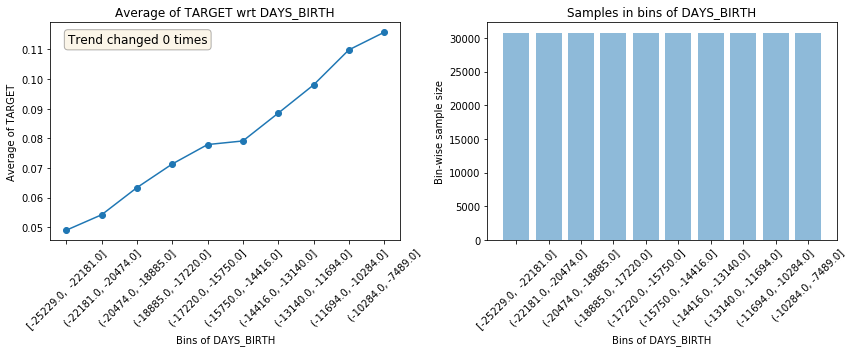

In [14]:
### 1 Feature exploration ###

from featexp import get_univariate_plots

# Plots drawn for all features if nothing is passed in feature_list parameter.
get_univariate_plots(data=train, target_col='TARGET', 
                     features_list=['DAYS_BIRTH'], bins=10)
# RESULT: The more they are young, the more the tend not to pay! From the article: " The plot tells us that customers with high negative values for DAYS_BIRTH (higher age) have lower default rates"

In [15]:
#### 2. Identifying noisy features ####

#Build a validation set
msk = np.random.rand(len(train)) < 0.6
trainset = train[msk].astype(np.float32)
validationset = train[~msk].astype(np.float32)

Plots for DAYS_EMPLOYED                                        
                                           Train data plots                                           
                                           Test data plots                                            
--------------------------------------------------------------------------------------------------------------




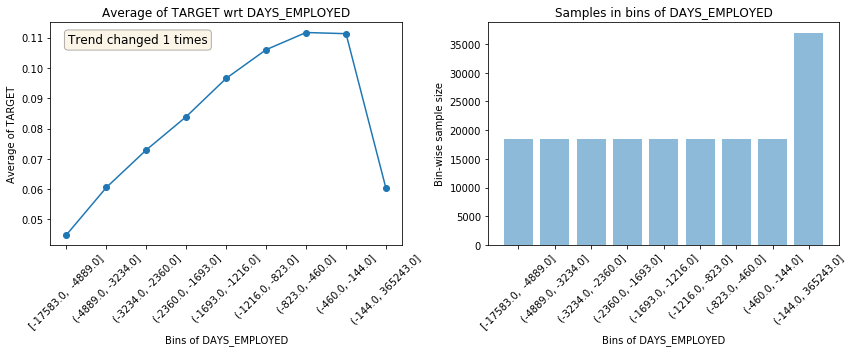

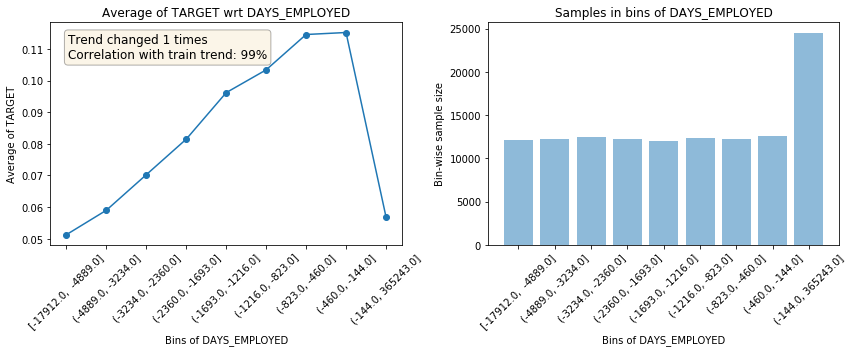

In [16]:
get_univariate_plots(data=trainset, target_col='TARGET', data_test=validationset, features_list=['DAYS_EMPLOYED'], bins=10)

#RESULT: High correlation between the trend in validation and train set, therefore should not be a noisy feature!
# What if the trend changes a lot tho? Well it might be true then that this its a symptom of noisyness nevertheless the considered bins migh differ 
# a lot in other features giving us a different trends in default rates.
# What should we do then? Cross Validation!

In [17]:
from featexp import get_trend_stats
stats = get_trend_stats(data=trainset, target_col='TARGET', data_test=validationset)

Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Only one bin created for FLAG_DOCUMENT_12. Correlation can't be calculated
Returning stats for all numeric features


In [18]:
stats

,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,SK_ID_CURR,5,5,-0.332408
1,NAME_CONTRACT_TYPE,0,0,1.000000
2,FLAG_OWN_CAR,0,0,1.000000
3,FLAG_OWN_REALTY,0,0,1.000000
4,CNT_CHILDREN,2,2,0.988799
...,...,...,...,...
232,WALLSMATERIAL_MODE_Panel,0,0,1.000000
233,"WALLSMATERIAL_MODE_Stone, brick",0,0,1.000000
234,WALLSMATERIAL_MODE_Wooden,0,0,1.000000
235,EMERGENCYSTATE_MODE_No,0,0,1.000000


In [19]:
#Cross validate to have more representative trend_correlations 
#10-Folds

total_trend_correlations=stats['Trend_correlation']
for i in range(0,9):
    msk = np.random.rand(len(train)) < 0.6
    trainset = train[msk].astype(np.float32)
    validationset = train[~msk].astype(np.float32)
    
    ith_stats = get_trend_stats(data=trainset, target_col='TARGET', data_test=validationset)
    ith_tc = ith_stats['Trend_correlation']
    
    total_trend_correlations += ith_tc

averaged_trend_correlations = total_trend_correlations / 10

Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Only one bin created for FLAG_DOCUMENT_12. Correlation can't be calculated
Returning stats for all numeric features
Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Returning stats for all numeric features
Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Returning stats for all numeric features
Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Returning stats for all numeric features
Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Returning stats for all numeric features


In [20]:
averaged_trend_correlations

0     -0.115646
1      1.000000
2      1.000000
3      1.000000
4      0.934223
         ...   
232    1.000000
233    1.000000
234    1.000000
235    1.000000
236    1.000000
Name: Trend_correlation, Length: 237, dtype: float64

In [21]:
#Now drop from our original train set all the columns we deduced to label as noisy w/ respect to the trend_correlation average and by using a treshold of 0.9.
#Meaning that, we consider as noisy features all the features which have averaged_trend_correlations smaller than 0.90. Strong assumption?

stats['Trend_correlation']=averaged_trend_correlations

#We also want to save SK_ID_CURR as it will be useful later
noisy_f= stats.loc[(stats['Feature'] != 'SK_ID_CURR') & (stats['Trend_correlation'] < 0.80)]['Feature'].reset_index()

train=train.drop(noisy_f['Feature'], axis=1)
test=test.drop(noisy_f['Feature'], axis=1)

In [22]:
#### 3. Anomalies ####
#Look around for anomalies by using the describe method
(train['DAYS_BIRTH'] / -365).describe()
#N: Those ages look reasonable. There are no outliers for the age on either the high or low end.


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [23]:
#How about the days of employment?
train['DAYS_EMPLOYED'].describe()
#N: Big outliers! Describe shows a guy who apparently has been working for 1k years :S (plus being a positive number)
#   Moreover, the mean is 174 years still unreal

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

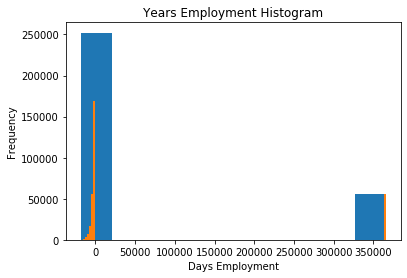

In [24]:
# Plot DAYS_EMPLOYED per years
train['DAYS_EMPLOYED'].plot.hist(title = 'Years Employment Histogram')
plt.xlabel('Days Employment')

# The plot shows a clearly bipartite distribution. Call anomalies the ones around 1k years and healthy the ones around 0
# Increase now the number of bits to actually see if such a distribution has bigger granularity
train['DAYS_EMPLOYED'].plot.hist(title = 'Years Employment Histogram', bins=150)
plt.xlabel('Days Employment')

In [25]:
#The previous plot gives us an insight: the anomalies appear to have all exactly 1k years of employment, lets check it analitically
anomalies = train[train['DAYS_EMPLOYED'] == 365243]
healthy = train[(train['DAYS_EMPLOYED'] >= -17912) & (train['DAYS_EMPLOYED'] <= 0)]
print("Number of anomalies with 1k years of work: %d" % len(anomalies))
print("Number of healty records: %d" % len(healthy))
print("Is there anyone missing?: %d" % (307511 - (len(healthy)+len(anomalies))) )

Number of anomalies with 1k years of work: 55374
Number of healty records: 252137
Is there anyone missing?: 0


In [26]:
#Once we have understood that all the anomalies lie in exactly the same outlier, we want to see if they also have some correlation with the ratio of defaults
print('The non-anomalies default on %0.2f%% of loans' % (100 * healthy['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anomalies['TARGET'].mean()))
#With respect to the default-ratio of the healthy, the anomalies have a lower default rate.

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans


In [27]:
#Therefore it seems like there is some correlation between the loans that was wrongly recorded (employment - wise) and the rate of defaults. Like they encode  hidden feature/s. We then might want to tell this to the classifier by explicitly making a new "employment-anomaly" feature. However, we also don't want to loose the idea of days of employment. That's why we will set a new common value to all the anomalies, such as the median of the healthy.

#Create an anomalous flag column
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
#Label it w/ 0 1
le = sklearn.preprocessing.LabelEncoder()
train['DAYS_EMPLOYED_ANOM']=le.transform(train['DAYS_EMPLOYED_ANOM'])

#Replace the anomalous values with median
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
train['DAYS_EMPLOYED'].fillna(train['DAYS_EMPLOYED'].median(), inplace=True)

#Note that the test follow the same distribution between anomaly and healthy DAYS_EMPLOYMENT. Therefore to the same preprocessing to the testset
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243

le = sklearn.preprocessing.LabelEncoder()
train['DAYS_EMPLOYED_ANOM']=le.transform(train['DAYS_EMPLOYED_ANOM'])

test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
test['DAYS_EMPLOYED'].fillna(test['DAYS_EMPLOYED'].median(), inplace=True)

In [28]:
train['DAYS_EMPLOYED_ANOM'].describe()

count     307511
unique         2
top        False
freq      252137
Name: DAYS_EMPLOYED_ANOM, dtype: object

In [3]:
test = pd.read_csv('../../data/test.csv', nrows=50)

In [4]:
#Take a look at the remaining columns to see if there are any salient feature to be inspected for anomalies
from IPython.display import display
pd.options.display.max_columns = None
display(test.describe())


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport:

(50, 186)

In [5]:
test['DAYS_EMPLOYED_ANOM']

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17     True
18    False
19    False
20    False
21    False
22     True
23    False
24    False
25    False
26     True
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36     True
37    False
38    False
39    False
40    False
41     True
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
Name: DAYS_EMPLOYED_ANOM, dtype: bool

In [30]:
#After and in-depth check of all the remaining features we did not find any substantial indication for anomalies. Plus, most of the remaining features are normalized hence difficult to interpret

In [31]:
#Save what is done so far
train.to_csv('../../data/train.csv', index=False)
test.to_csv('../../data/test.csv', index=False)

In [32]:
# Continue to the merge phase